# SIECI NEURONOWE - ćwiczenie 3

To ćwiczenie obejmuje algorytm propagacji wstecznej, który powinien być znany już z wykładu. Na wykładzie podane zostały wzory na poszczególne parametry na różnych warstwach sieci neuronowych i ich wyprowadzenie, na laboratoriach zajmiemy się implementacją. Propagacja wsteczna jest po prostu zastosowaniem reguły łańcuchowej:

𝜕𝐿 / 𝜕𝑥 = (𝜕𝐿 / 𝜕𝑦) (𝜕𝑦 / 𝜕𝑥)

W wyliczaniu gradientu kosztu modelu po parametrach. Dla użytej konwencji notacji:
-  Operujemy na wektorach i mnożeniu macierzowym, kolejność ma znaczenie
-  L jest skalarem, w notacji gdzie x to wektor kolumnowy, 𝜕𝐿/𝜕𝑥 jest wektorem o wymiarze odpowiadającym xT (aby zgadzało się mnożenie macierzowe)
-  𝜕𝑦/𝜕𝑥 to macierz pochodnych cząstkowych wszystkich wyjść po wszystkich wejściach o wymiarach (dimy, dimx)

(Istnieje też konwencja odwrotna, jeżeli natkniesz się na nią szukając materiałów, tutaj ściągawka: https://en.wikipedia.org/wiki/Matrix_calculus#Layout_conventions)

Jak ta matematyka przekłada się na implementację? Weźmy przykład dowolnej funkcji element-wise, tzn. takiej która aplikuje przekształcenie niezależnie od siebie do każdego elementu wektora np.

𝑦 = 𝑓(𝑥) = 𝑥^2

Dla skalarów wiemy, że pochodna z tej funkcji to f’(x) = 2x czyli jeśli nałożymy na nią kolejną funkcję, tak że h(x) = g(f(x)), wtedy h’(x) = g’(x)2x.

Dla wektorów powinniśmy mieć jako 𝜕𝑦/𝜕𝑥 macierz kwadratową (dimx, dimx) i wykorzystać ją w regule łańcuchowej, ale zauważmy, że wszystkie elementy tej macierzy poza diagonalą będą zerowe, natomiast diagonala to po prostu elementy wektora 2x. 

Pamiętajmy też że wyliczanie odpowiednich wartości wyjściowych z każdej operacji musi odbyć się w kolejności tych operacji, natomiast wyliczanie gradientu po konkretnych wejściach – w kolejności odwrotnej. Stąd jeżeli chcemy zaimplementować operację: podniesienie wektora do kwadratu, w praktyce będziemy to robić mniej więcej tak:

// x.shape=(x,1), żeby zgadzać się z opisaną wyżej konwencją zapisu. W backward() potrzebna będzie transpozycja

def forward(x):

    cache_x = x

    return x*x

// derivative_y.shape=(1,x)

def backward(derivative_y):

    return derivative_y*2*cache_x.transpose()

Istotne jest tutaj że:
- Przy przejściu w przód, musimy zapisywać wartość wektora x na potrzeby późniejszego przejścia po operacjach wstecz
- Możemy zaimplementować pochodną/gradient jako funkcje backward, która na wejściu przyjmuje wyliczone do tej pory 𝜕𝐿/𝜕𝑦 , zaś na wyjściu daje 𝜕𝐿/𝜕𝑥
- backward to nie zawsze musi być pełnym mnożeniem przez 𝜕𝑦/𝜕𝑥, np. wyżej przemnożenie przez macierz diagonalną jest zastąpione numpy’owym operatorem *, czyli mnożeniem element-wise wektorów. Efekt jest ten sam, możemy skorzystać z uproszczenia
- W obrębie backward, jeżeli korzystamy z uczonych parametrów modelu, powinniśmy wyliczyć i zapisać gradient – pochodne cząstkowe po tych parametrach
- Jeżeli każda operacja jaką wykorzystujemy ma zaimplementowane te dwie funkcje, możemy bez problemu zbudować dowolną ich sekwencję i wyliczyć gradienty na dowolnym poziomie tej sekwencji. 

Zadaniem na dwa kolejne laboratoria jest zbudowanie modelu wielowarstwowego sieci neuronowej z dowolną funkcją aktywacji i funkcja kosztu taką, jak dla regresji logistycznej. Następnie należy przebadać jak model zachowuje się na zbiorze heart disease dla:
- Różnej wymiarowości warstwy ukrytej
- Różnej wartości współczynnika uczenia
- Różnych odchyleń standardowych przy inicjalizacji wag
- Danych znormalizowanych i nieznormalizowanych
- Różnej liczby warstw

Ćwiczenie oceniane jest w skali 0-20 pkt.

## Kod do zadania

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from copy import deepcopy
import time

# --- USTAWIENIA ---
RANDOM_SEED = 50
np.random.seed(RANDOM_SEED)

DATA_PATH = '../heart-disease/processed.cleveland.data'
COLUMN_NAMES = ['age', 'sex', 'cp', 'trestbps', 'chol', 'fbs', 'restecg',
                'thalach', 'exang', 'oldpeak', 'slope', 'ca', 'thal', 'num']

# --- LADOWANIE DANYCH ---
def load_and_preprocess(path=DATA_PATH, normalize=True):
    df = pd.read_csv(path, header=None, names=COLUMN_NAMES, encoding='latin1')
    df.replace('?', np.nan, inplace=True)

    for c in df.columns:
        df[c] = pd.to_numeric(df[c], errors='coerce')
    df = df.dropna().reset_index(drop=True)
    
    df['target'] = (df['num'] > 0).astype(int)
    df.drop(columns=['num'], inplace=True)

    X = df.drop(columns=['target']).values.astype(np.float64)
    y = df['target'].values.astype(np.int64).reshape(-1, 1)

    if normalize:
        mu = X.mean(axis=0)
        sigma = X.std(axis=0)
        sigma[sigma == 0] = 1.0
        X = (X - mu) / sigma
    return X, y

# --- FUNKCJE AKTYWACJI ---
def sigmoid(z):
    return 1.0 / (1.0 + np.exp(-z))

def sigmoid_deriv(a):
    return a * (1 - a)

def relu(z):
    return np.maximum(0, z)

def relu_deriv(z):
    return (z > 0).astype(float)

# --- WARSTWA LINIOWA ---
class LinearLayer:
    def __init__(self, in_dim, out_dim, weight_std=0.01):
        self.W = np.random.randn(in_dim, out_dim) * weight_std
        self.b = np.zeros((1, out_dim))
        self.x_cache = None
        self.dW = None
        self.db = None

    def forward(self, x):
        self.x_cache = x
        return x.dot(self.W) + self.b

    def backward(self, d_out):
        x = self.x_cache
        self.dW = x.T.dot(d_out) / x.shape[0]
        self.db = np.mean(d_out, axis=0, keepdims=True)
        dx = d_out.dot(self.W.T)
        return dx

    def step(self, lr):
        self.W -= lr * self.dW
        self.b -= lr * self.db

# --- COST FUNCTION ---
def binary_cross_entropy(y_true, y_pred):
    eps = 1e-12
    y_pred = np.clip(y_pred, eps, 1-eps)
    loss = - (y_true * np.log(y_pred) + (1 - y_true) * np.log(1 - y_pred))
    return loss.mean()

# --- SIEC NEURONOWA ---
class NN:
    def __init__(self, layer_dims, activation='relu', weight_std=0.01):
        self.layers = []
        self.activations = []

        for i in range(len(layer_dims)-1):
            l = LinearLayer(layer_dims[i], layer_dims[i+1], weight_std=weight_std)
            self.layers.append(l)

            if i < len(layer_dims)-2:
                if activation == 'relu':
                    self.activations.append('relu') 
                elif activation == 'sigmoid':
                    self.activations.append('sigmoid')
                else:
                    raise ValueError('Nieznana funkcja aktywacji')
            else:
                self.activations.append('sigmoid')  # ostatnia warstwa

        self.z_caches = []
        self.out_cache = None

    def forward(self, x):
        out = x
        self.z_caches = []

        for layer, act in zip(self.layers, self.activations):
            z = layer.forward(out)
            self.z_caches.append(z)
            if act == 'relu':
                out = relu(z)
            elif act == 'sigmoid':
                out = sigmoid(z)
            else:
                raise ValueError('Unknown act')

        self.out_cache = out
        return out

    def backward(self, y_true):
        y_pred = self.out_cache
        N = y_true.shape[0]
        dA = (y_pred - y_true) / N
        d_out = dA

        for i in reversed(range(len(self.layers))):
            act = self.activations[i]
            z = self.z_caches[i]

            if act == 'relu':
                dZ = d_out * relu_deriv(z)
            elif act == 'sigmoid':
                a = sigmoid(z)
                dZ = d_out * sigmoid_deriv(a)
            else:
                raise ValueError('Unknown act')

            d_out = self.layers[i].backward(dZ)

    def step(self, lr):
        for layer in self.layers:
            layer.step(lr)


    def predict_proba(self, X):
        return self.forward(X)

    def predict(self, X, threshold=0.5):
        probs = self.predict_proba(X)
        return (probs >= threshold).astype(int)

# --- METRYKA ---
def accuracy(y_true, y_pred):
    return (y_true.flatten() == y_pred.flatten()).mean()

# --- TRENING ---
def train_model(model, X_train, y_train, X_val=None, y_val=None,
                epochs=100, lr=0.01, batch_size=32, verbose=True):
    N = X_train.shape[0]
    history = {'train_loss': [], 'train_acc': [], 'val_loss': [], 'val_acc': []}

    for epoch in range(1, epochs+1):
        perm = np.random.permutation(N)
        X_sh = X_train[perm]
        y_sh = y_train[perm]

        for i in range(0, N, batch_size):
            xb = X_sh[i:i+batch_size]
            yb = y_sh[i:i+batch_size]
            model.forward(xb)
            model.backward(yb)
            model.step(lr)

        y_train_pred = model.predict_proba(X_train)
        train_loss = binary_cross_entropy(y_train, y_train_pred)
        train_acc = accuracy(y_train, (y_train_pred >= 0.5).astype(int))
        history['train_loss'].append(train_loss)
        history['train_acc'].append(train_acc)

        if X_val is not None:
            y_val_pred = model.predict_proba(X_val)
            val_loss = binary_cross_entropy(y_val, y_val_pred)
            val_acc = accuracy(y_val, (y_val_pred >= 0.5).astype(int))
            history['val_loss'].append(val_loss)
            history['val_acc'].append(val_acc)

            if verbose and (epoch % max(1, epochs//10) == 0 or epoch==1 or epoch==epochs):
                print(f"Epoch {epoch}/{epochs} - train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}, val_loss: {val_loss:.4f}, val_acc: {val_acc:.4f}")
        else:
            if verbose and (epoch % max(1, epochs//10) == 0 or epoch==1 or epoch==epochs):
                print(f"Epoch {epoch}/{epochs} - train_loss: {train_loss:.4f}, train_acc: {train_acc:.4f}")

    return history

# --- URUCHAMIANIE EKSPERYMENTÓW ---
def run_experiment(X, y, hidden_dims=[8], num_layers=2, activation='relu',
                   learning_rate=0.01, weight_std=0.01, normalize=True,
                   epochs=100, batch_size=16, val_split=0.2, verbose=False):

    X_proc = X.copy()
    N = X_proc.shape[0]
    idx = np.random.permutation(N)
    val_N = int(N * val_split)
    val_idx = idx[:val_N]
    train_idx = idx[val_N:]
    X_train, y_train = X_proc[train_idx], y[train_idx]
    X_val, y_val = X_proc[val_idx], y[val_idx]

    input_dim = X.shape[1]
    output_dim = 1

    if isinstance(hidden_dims, int):
        hidden_dims = [hidden_dims] * (num_layers-1)
    else:
        if len(hidden_dims) != max(0, num_layers-1):
            if len(hidden_dims) < max(0, num_layers-1):
                last = hidden_dims[-1] if len(hidden_dims)>0 else 8
                hidden_dims = (hidden_dims + [last]*max(0, num_layers-1 - len(hidden_dims)))[:max(0, num_layers-1)]
            else:
                hidden_dims = hidden_dims[:max(0, num_layers-1)]

    layer_dims = [input_dim] + hidden_dims + [output_dim]
    model = NN(layer_dims, activation=activation, weight_std=weight_std)
    history = train_model(model, X_train, y_train, X_val, y_val,
                          epochs=epochs, lr=learning_rate, batch_size=batch_size, verbose=verbose)

    return {
        'model': model,
        'history': history,
        'train_acc': history['train_acc'][-1],
        'val_acc': history['val_acc'][-1] if len(history['val_acc'])>0 else None
    }

# --- GRID SEARCH ---
def grid_search(X, y, param_grid, common_args, epochs=150):
    results = []
    for i, p in enumerate(param_grid):
        config = deepcopy(common_args)
        config.update(p)
        print(f"\n=== Run {i+1}/{len(param_grid)}: {p} ===")
        t0 = time.time()
        res = run_experiment(X, y,
                             hidden_dims=config.get('hidden_dims', [8]),
                             num_layers=config.get('num_layers', 2),
                             activation=config.get('activation', 'relu'),
                             learning_rate=config.get('learning_rate', 0.01),
                             weight_std=config.get('weight_std', 0.01),
                             normalize=config.get('normalize', True),
                             epochs=epochs,
                             batch_size=config.get('batch_size', 16),
                             val_split=config.get('val_split', 0.2),
                             verbose=config.get('verbose', False))
        t1 = time.time()
        print(f"Done in {(t1-t0):.1f}s - train_acc: {res['train_acc']:.3f}, val_acc: {res['val_acc']:.3f}")
        results.append((config, res))
    return results

# --- WYKRESY ---
def plot_experiment(results, title):
    plt.figure(figsize=(12, 6))
    
    # Loss
    plt.subplot(1, 2, 1)
    for config, res in results:
        history = res['history']
        label = f"{config.get('hidden_dims', '')}, lr={config.get('learning_rate', '')}, std={config.get('weight_std', '')}, norm={config.get('normalize', '')}"
        if len(history['val_loss']) > 0:
            plt.plot(history['val_loss'], label=label)
        else:
            plt.plot(history['train_loss'], label=label)
    plt.title(f"{title} — Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Strata (binary cross-entropy)")
    plt.grid(True, linestyle='--', alpha=0.5)

    # Accuracy
    plt.subplot(1, 2, 2)
    for config, res in results:
        history = res['history']
        label = f"{config.get('hidden_dims', '')}, lr={config.get('learning_rate', '')}, std={config.get('weight_std', '')}, norm={config.get('normalize', '')}"
        if len(history['val_acc']) > 0:
            plt.plot(history['val_acc'], label=label)
        else:
            plt.plot(history['train_acc'], label=label)
    plt.title(f"{title} — Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Dokładność")
    plt.grid(True, linestyle='--', alpha=0.5)

    handles, labels = plt.gca().get_legend_handles_labels()
    plt.figlegend(handles, labels, loc='lower center', ncol=2, fontsize='small', 
                  bbox_to_anchor=(0.5, -0.05), title='Konfiguracje')

    plt.tight_layout()
    plt.subplots_adjust(bottom=0.2)
    plt.show()

## Przygotowanie do Eksperymentow 

In [62]:
X_norm, y = load_and_preprocess(DATA_PATH, normalize=True)
X_nonorm, _ = load_and_preprocess(DATA_PATH, normalize=False)

common = {
    'batch_size': 16,
    'val_split': 0.2,
    'activation': 'relu',
    'verbose': False
}

## Eksperyment 1: Wpływ liczby neuronów w warstwie ukrytej


=== Run 1/6: {'hidden_dims': [1], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.1s - train_acc: 0.529, val_acc: 0.576

=== Run 2/6: {'hidden_dims': [2], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.0s - train_acc: 0.538, val_acc: 0.542

=== Run 3/6: {'hidden_dims': [4], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.0s - train_acc: 0.555, val_acc: 0.475

=== Run 4/6: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.0s - train_acc: 0.529, val_acc: 0.576

=== Run 5/6: {'hidden_dims': [16], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.1s - train_acc: 0.550, val_acc: 0.492

=== Run 6/6: {'hidden_dims': [32], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.1s - train_acc: 0.538, val_acc: 0.542


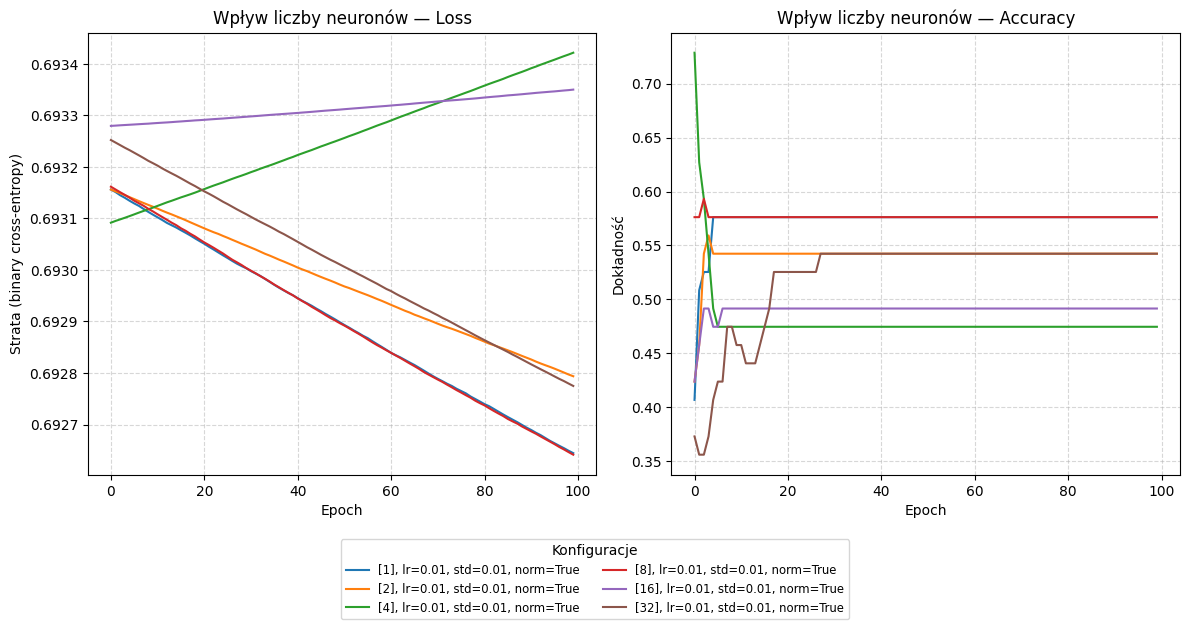

In [63]:
grid_sizes = [
    {'hidden_dims': [1],  'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True},
    {'hidden_dims': [2],  'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True},
    {'hidden_dims': [4],  'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True},
    {'hidden_dims': [8],  'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True},
    {'hidden_dims': [16], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True},
    {'hidden_dims': [32], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True},
]
res = grid_search(X_norm, y, grid_sizes, common, epochs=100)
plot_experiment(res, "Wpływ liczby neuronów")

### Wnioski dot. poszczegolnych przypadkow: 
<i>Wazna obserwacja: W tym eksperymencie korzystamy z pojedynczej sieci neuronowej</i>

<b>Wykres Straty: </b>

najlepiej wypadaja zielona i czerwona, poniewaz notuja najwiekszy spadek. W przypadku 

<b>Wykres Dokladnosci:</b>

jest podobnie, zielona i czerwona wypadaja najlepiej. Widac jednak ciekawą rzecz, mianowicie czerwona funkcja, posiadająca najwieksza liczbe neuronow, czasem na poczatku potrafi miec najgorsze statystyki, ale ostatecznie konczy z najlepszymi. Co to znaczy? Ze jest niestabilna i ciezka w uczeniu, ale ostatecznie osiaga najlepszy z wynikow

### Wnioski ogolne:

- Dla wszystkich przykladow wykres funkcji straty wyglada srednio, bo spadek jest niewielki
- Funkcje z wieksza iczba neuronów w warstwie ukrytej moga dawać wyższą ostateczną dokładność, ale uczenie jest wolniejsze i niestabilne
- Optymalna liczba neuronow wynosi tutaj zazwyczaj 16

<i>PS. Po wielokrotnym przeladowaniu za kazdym razem te wykresy wygladaja inaczej, ale to sa ogolne wnioski co udalo mi sie ustalic</i>


## Eksperyment 2: Wpływ learning rate


=== Run 1/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.0005, 'normalize': True} ===
Done in 0.1s - train_acc: 0.542, val_acc: 0.542

=== Run 2/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.001, 'normalize': True} ===
Done in 0.0s - train_acc: 0.538, val_acc: 0.593

=== Run 3/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.0s - train_acc: 0.555, val_acc: 0.475

=== Run 4/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 0.0s - train_acc: 0.534, val_acc: 0.559

=== Run 5/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.2, 'normalize': True} ===
Done in 0.1s - train_acc: 0.513, val_acc: 0.644


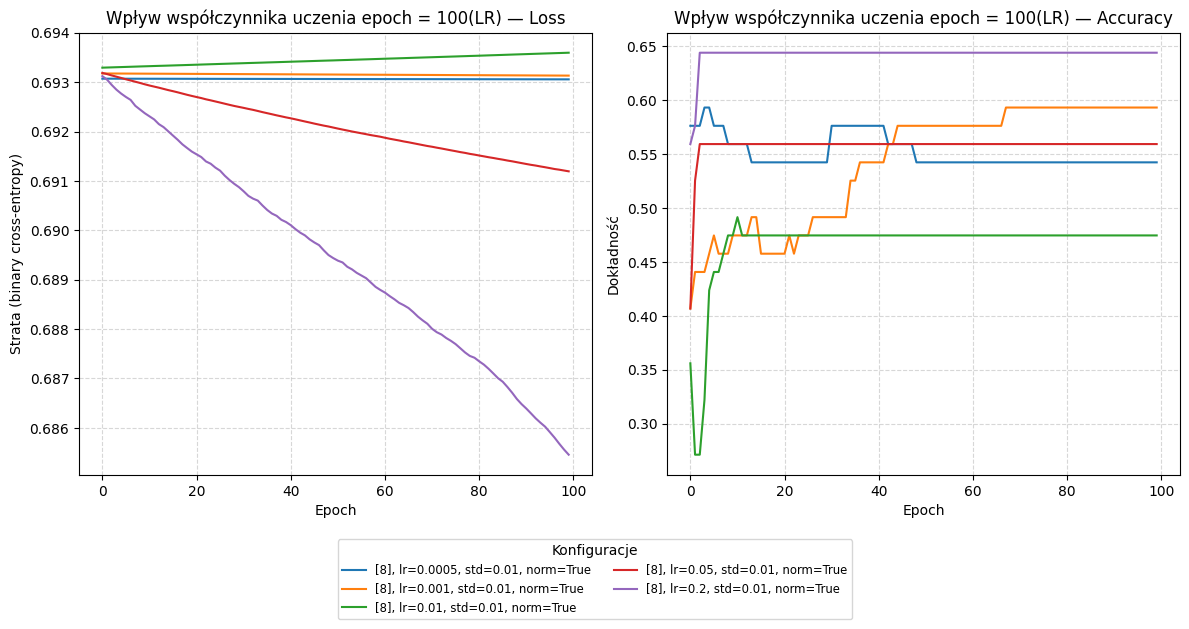


=== Run 1/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.0005, 'normalize': True} ===
Done in 0.5s - train_acc: 0.550, val_acc: 0.492

=== Run 2/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.001, 'normalize': True} ===
Done in 0.5s - train_acc: 0.534, val_acc: 0.559

=== Run 3/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.5s - train_acc: 0.550, val_acc: 0.492

=== Run 4/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 0.5s - train_acc: 0.861, val_acc: 0.780

=== Run 5/5: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.2, 'normalize': True} ===
Done in 0.5s - train_acc: 0.857, val_acc: 0.915


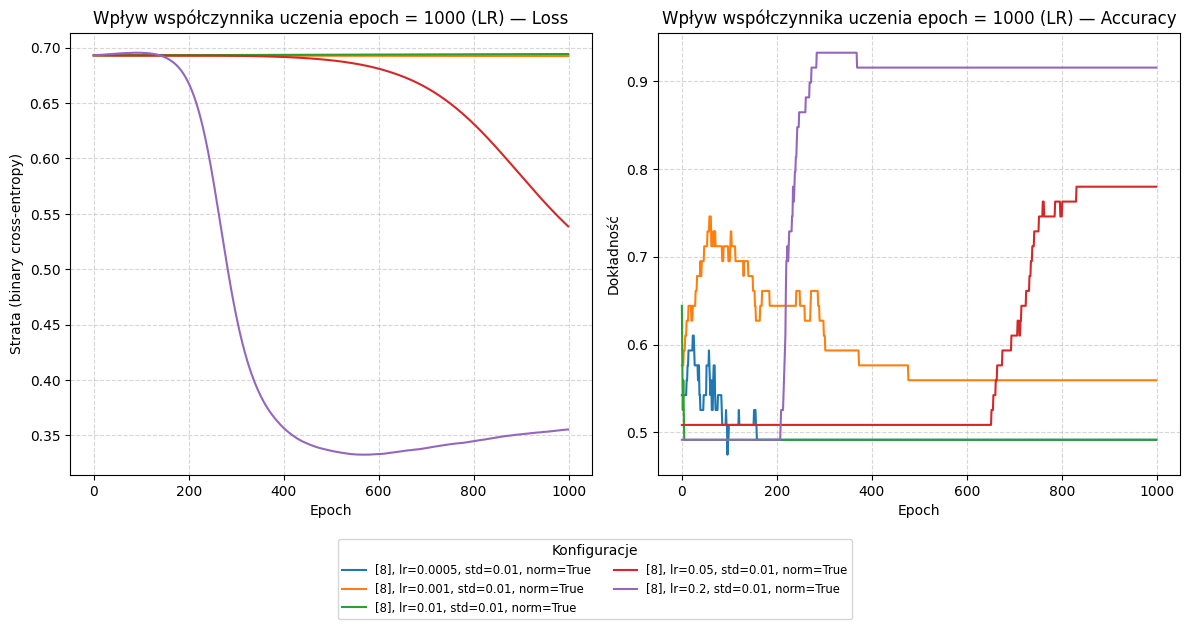

In [64]:
grid_lr = [
    # {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.0000, 'normalize': True},
    {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.0005, 'normalize': True},
    {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.001,  'normalize': True},
    {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.01,   'normalize': True},
    {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.05,   'normalize': True},
    {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.20,   'normalize': True},
]
res = grid_search(X_norm, y, grid_lr, common, epochs=100)
plot_experiment(res, "Wpływ współczynnika uczenia epoch = 100(LR)")

res = grid_search(X_norm, y, grid_lr, common, epochs=1000)
plot_experiment(res, "Wpływ współczynnika uczenia epoch = 1000 (LR)")

### Wnioski dot. poszczegolnych przypadkow: 
<i> Wykonano do 100 epoch </i>

<b>Wykres Straty: </b>
- Niebieski (LR=0.0005) – praktycznie płaska linia, LR jest zbyt mały, więc model uczy się bardzo powoli.
- Pomarańczowy (LR=0.001) – lekko spada, akceptowalny, ale minimalny spadek.
- Zielony (LR=0.01) – strata spada najszybciej, LR jest odpowiedni, model uczy się efektywnie.
- Czerwony (LR=0.05) – strata rośnie z czasem, zdecydowanie za duży learning rate, model „nie uczy się” i w zasadzie pogarsza się.

<b>Wykres Dokladnosci:</b>
- Czerwony (LR=0.05) - dokładność spada → LR za duży.
- Zielony (LR=0.01) - dokładność rośnie i jest najwyższa → optymalny LR.
- Niebieski i pomarańczowy - minimalny wzrost, LR za mały, uczenie wolne.

### Wnioski ogolne:

- Zbyt mały LR - powolne uczenie, strata prawie nie spada.
- Optymalny LR - strata spada, dokładność rośnie (zielony).
- Zbyt duży LR - strata rośnie, dokładność spada (czerwony), model się „rozjeżdża”.

<i>PS. W ramach eksperymentu dodalem i chwilowo zakomentowalem lr=0 oraz lr=0.2, ale one wychodzily dosc zabawnie, mianowicie 0.2 nigdy nie bylo liniowe i zawsze bylo parabola, a accuracy mialo liniowe, a zero jak zero, liniowy loss i liniowe accuracy. Poniewaz tylko utrudnialy odczytywanie wykresu zostaly one ukryte </i>

PS 2. Po Zmianie na 1000 epoch zaszly fundamentalne zmiany. Najlepszym LR okazalo sie byc 0.05, poniewaz wyniki uczenia widac bardzo pozno, ale zdecydowanie je widac! Dochodzi równiez do bardzo ladnych wyników dokladnosci. Czasem tez 0.2 potrafi wyskoczyc jeszcze wyzej ale wszystko zalezy od przypadku.

## Eksperyment 3: Wpływ odchylenia inicjalizacji wag


=== Run 1/3: {'hidden_dims': [16, 8], 'num_layers': 3, 'weight_std': 0.001, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.7s - train_acc: 0.538, val_acc: 0.542

=== Run 2/3: {'hidden_dims': [16, 8], 'num_layers': 3, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.7s - train_acc: 0.534, val_acc: 0.559

=== Run 3/3: {'hidden_dims': [16, 8], 'num_layers': 3, 'weight_std': 0.1, 'learning_rate': 0.01, 'normalize': True} ===
Done in 0.7s - train_acc: 0.668, val_acc: 0.695


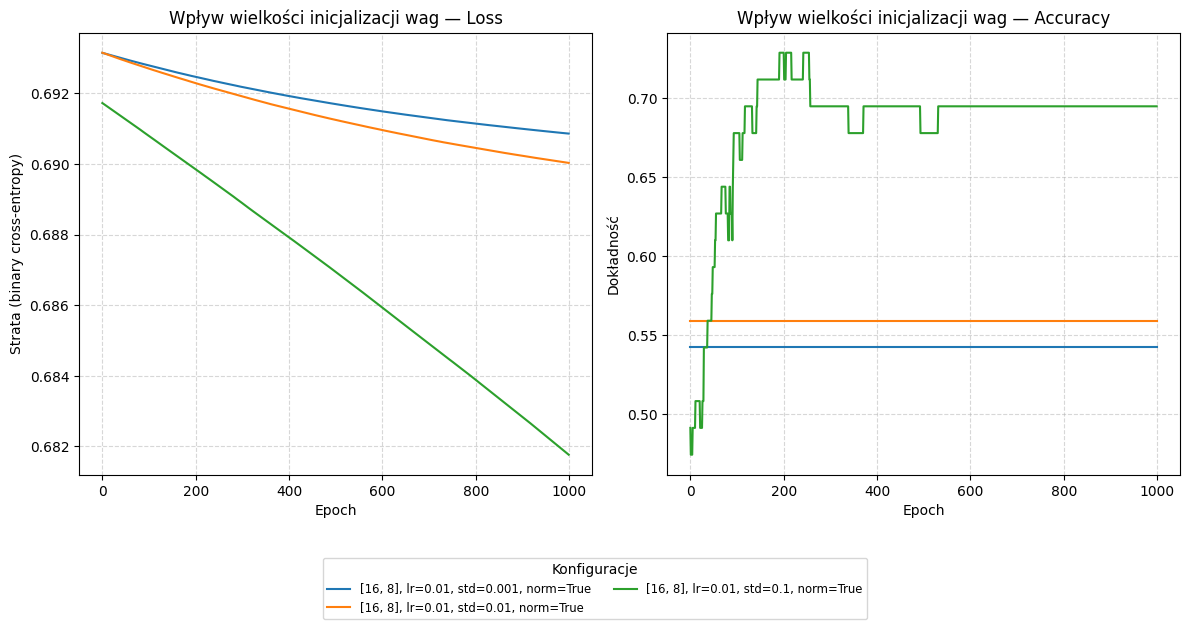

In [65]:
grid_init = [
    {'hidden_dims': [16, 8], 'num_layers': 3, 'weight_std': 0.001, 'learning_rate': 0.01, 'normalize': True},
    {'hidden_dims': [16, 8], 'num_layers': 3, 'weight_std': 0.01,  'learning_rate': 0.01, 'normalize': True},
    {'hidden_dims': [16, 8], 'num_layers': 3, 'weight_std': 0.1,   'learning_rate': 0.01, 'normalize': True},
]
res = grid_search(X_norm, y, grid_init, common, epochs=1000)
plot_experiment(res, "Wpływ wielkości inicjalizacji wag")

### Wnioski dot. poszczegolnych przypadkow: 

<b>Wykres Straty: </b>
- Niebieski (std=0.001) – zwykle idzie lekko w dol, ale najczesciej gorzej niz pomaranczowa
- Pomarańczowy (std=0.01) – zwykle idzie w dol badz jest zblizone do liniowego, ale zawsze jest 1 lub 2 najlepsze. 
- Zielony (std=0.1) – zwykle albo idzie do góry albo jest liniowe, po czym mozemy wnioskowac ze jest to za duze odchylenie standardowe

<b>Wykres Dokladnosci:</b>
Tutaj generalnie wyniki przy kazdym wykonaniu wychodza inne ale obserwacje wskazuja nastepunaco
- Niebieski (std=0.001) – idzie duzo stabilniej niz zielona, ale sa wieksze rozbieznosci pomiedzy tym jakie accuracy wychodzi przy trenowaniu.
- Pomarańczowy (std=0.01) – zwykle idzie dosc tabilnie, zawsze jest 1 lub 2 najlepszym. 
- Zielony (std=0.1) – Zawsze niestabilny, czesto konczy na dole, czasem uda mu sie trafic rowniez na szczyt

### Wnioski ogolne:

- Optymalna opcja wydaje sie byc std=0.01, praktycznie zawsze funkcja straty jest malejaca w zaleznosci od epoch, i accuracy wychodzi najstabilniej.

### Eksperyment 4: Normalizacja vs brak normalizacji


=== Run 1/2: {'hidden_dims': [32, 16, 8], 'num_layers': 4, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True} ===
Done in 1.1s - train_acc: 0.538, val_acc: 0.542

=== Run 2/2: {'hidden_dims': [32, 16, 8], 'num_layers': 4, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': False} ===
Done in 1.1s - train_acc: 0.550, val_acc: 0.492


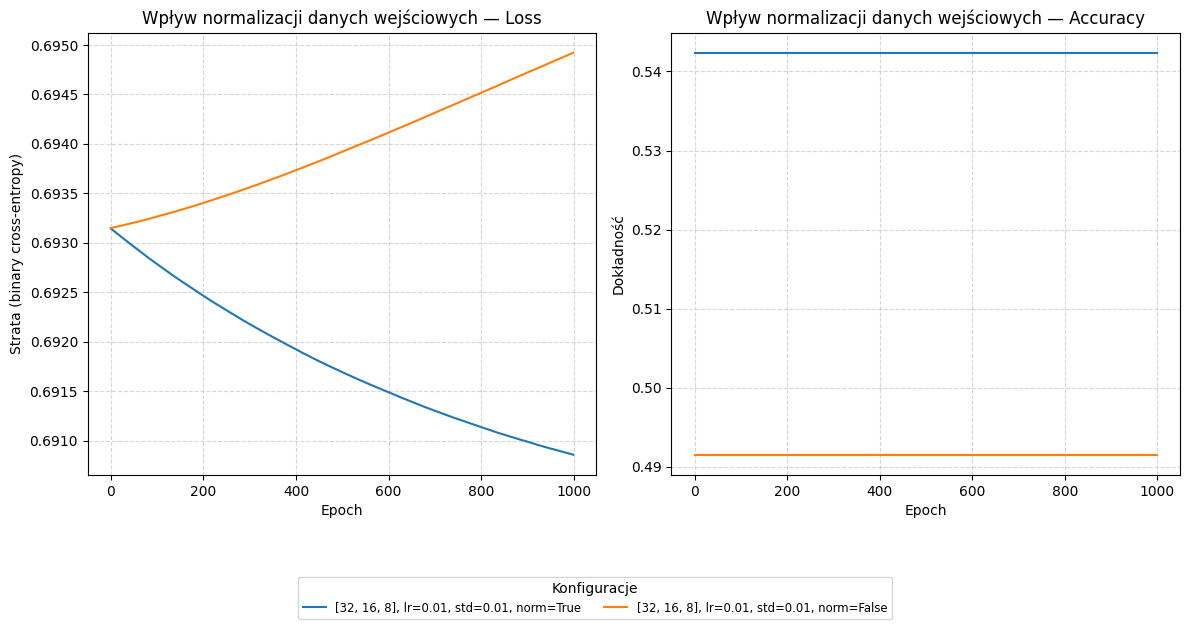

In [66]:
grid_norm = [
    {'hidden_dims': [32,16,8], 'num_layers': 4, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': True},
    {'hidden_dims': [32,16,8], 'num_layers': 4, 'weight_std': 0.01, 'learning_rate': 0.01, 'normalize': False},
]
res = grid_search(X_norm, y, grid_norm, common, epochs=1000)
plot_experiment(res, "Wpływ normalizacji danych wejściowych")

### Wnioski ogónle:
Po wielokrotnym przeladowaniu i zmianach ustawien sieci doszedlem do wniosku ze w okolo 3/5 przypadkow wykres straty do epochow spada bardziej przy normalizacji, i podobnie jesli chodzi o accuracy, rowniez w ok 60% przypadkow wychodzi lepsze, ale nie jest to zawsze case. Jednak wydaje się jakby powinno to byc dobra praktyka ogolnie, bo na pewno sa przypadki, kiedy jest to bardzo potrzebne, mozliwe po prostu ze to nie jest ten zbior danych.

## Eksperyment 5: Liczba warstw (głębokość sieci)


=== Run 1/4: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 0.1s - train_acc: 0.563, val_acc: 0.441

=== Run 2/4: {'hidden_dims': [16, 8], 'num_layers': 3, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 0.1s - train_acc: 0.550, val_acc: 0.492

=== Run 3/4: {'hidden_dims': [32, 16, 8], 'num_layers': 4, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 0.1s - train_acc: 0.538, val_acc: 0.542

=== Run 4/4: {'hidden_dims': [64, 32, 16, 8], 'num_layers': 5, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 0.1s - train_acc: 0.525, val_acc: 0.593


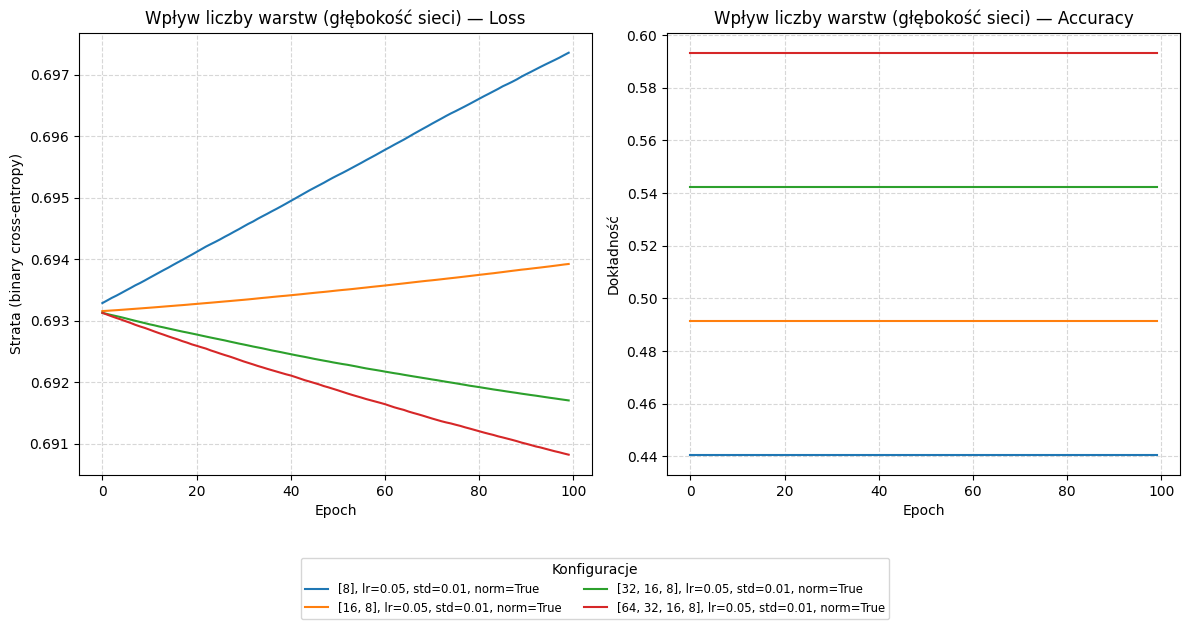


=== Run 1/4: {'hidden_dims': [8], 'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 0.5s - train_acc: 0.845, val_acc: 0.864

=== Run 2/4: {'hidden_dims': [16, 8], 'num_layers': 3, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 0.7s - train_acc: 0.546, val_acc: 0.508

=== Run 3/4: {'hidden_dims': [32, 16, 8], 'num_layers': 4, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 1.0s - train_acc: 0.534, val_acc: 0.559

=== Run 4/4: {'hidden_dims': [64, 32, 16, 8], 'num_layers': 5, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True} ===
Done in 1.4s - train_acc: 0.555, val_acc: 0.475


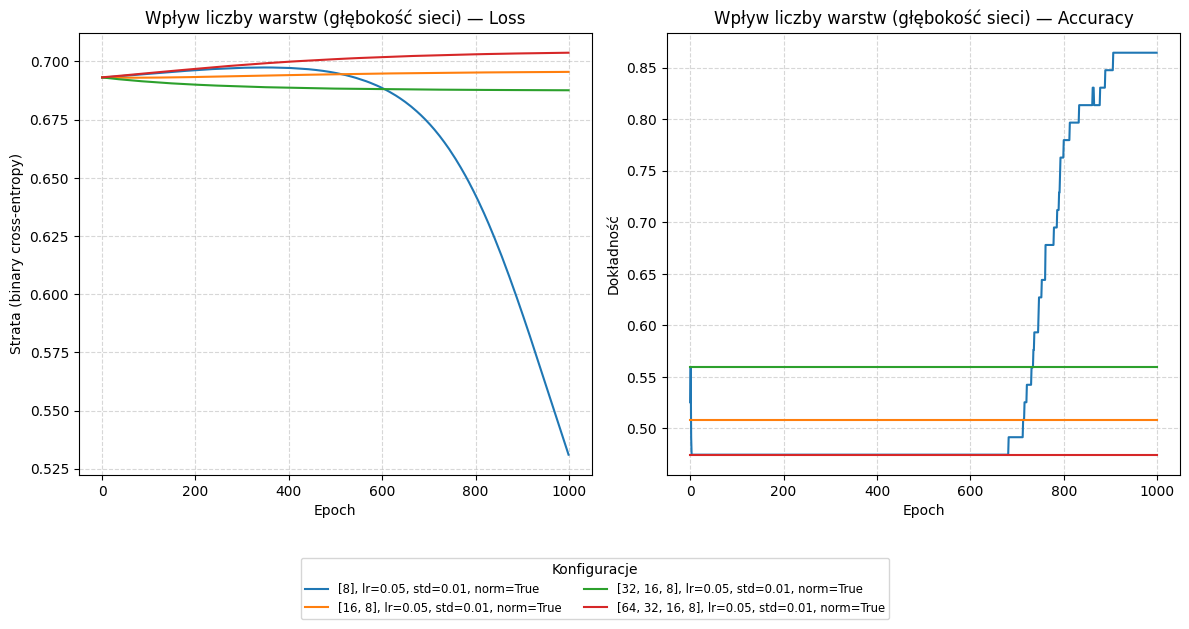

In [67]:
grid_layers = [
    {'hidden_dims': [8],          'num_layers': 2, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True},
    {'hidden_dims': [16, 8],      'num_layers': 3, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True},
    {'hidden_dims': [32, 16, 8],  'num_layers': 4, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True},
    {'hidden_dims': [64, 32, 16, 8], 'num_layers': 5, 'weight_std': 0.01, 'learning_rate': 0.05, 'normalize': True}
]
res = grid_search(X_norm, y, grid_layers, common, epochs=100)
plot_experiment(res, "Wpływ liczby warstw (głębokość sieci)")

res = grid_search(X_norm, y, grid_layers, common, epochs=1000)
plot_experiment(res, "Wpływ liczby warstw (głębokość sieci)")

### Wnioski dot. poszczegolnych przypadkow: 
<i>Informacja ogólna jak przy kazdym innym przykladzie: przy kazdym wywolaniu wychodzilo inaczej wiec przekaze ogolne przemyslenia i wnioski. Znalazlem wiec przyklad, ktory pokazuje plus minus to co powinien. (odniesienie do wykresow jest do tymczasowej wersji, ktora po przeladowaniu się zmieni)</i>

#### Wnioski do 100 epoch
<b>Wykres Straty: </b>
- czerwona (4 warstwowa) wypada zdecydowanie najlepiej, jest zdecydowanie najlepsza, posiada najwiekszy spadek 
- zielona i zolta (2-3 warstwy) wypadaja gorzej, zaliczaja niewielki wzrost, ale w innych przypadkach nie zawsze tak bylo. Generalnie normalnie rowniez maja najczesciej spadek na tej funkcji
- niebieska(1 warstwa) w tym przypadku zdecydowanie najgorzej, 

<b>Wykres Dokladnosci:</b>
Tutaj generalnie wyniki przy kazdym wykonaniu wychodza inne ale obserwacje wskazuja nastepunaco
- Niebieski (std=0.001) – idzie duzo stabilniej niz zielona, ale sa wieksze rozbieznosci pomiedzy tym jakie accuracy wychodzi przy trenowaniu.
- Pomarańczowy (std=0.01) – zwykle idzie dosc tabilnie, zawsze jest 1 lub 2 najlepszym. 
- Zielony (std=0.1) – Zawsze niestabilny, czesto konczy na dole, czasem uda mu sie trafic rowniez na szczyt

#### Wnioski do 1000 epoch
- Jednowarstwowa sieć (niebieska) pokazuje stabilne zachowanie przy dużej liczbie wywołań.
- Może to wynikać z prostoty danych: mało skomplikowane zależności, mała liczba przypadków → sieć o mniejszej liczbie parametrów szybciej się uczy i nie przeucza.
- Przy długim treningu prostsze sieci mają też mniejszą wariancję wyników między wywołaniami.

## Podsumowanie Ogólne:

- Propagacja wsteczna działa efektywnie przy odpowiednim doborze hiperparametrów​
- Nie ma uniwersalnych wartości - optymalne parametry zależą od problemu, danych i architektury sieci​  
- Inicjalizacja losowa wprowadza zmienność wyników - wiele eksperymentów daje różne rezultaty przy każdym uruchomieniu (moze to byc plus, moze to byc minus, w zaleznosci od sytuacji)​  
- Zbyt proste modele nie uczą się dobrze przy skoplikowanych i zlozenie powiazanych danych, zbyt złożone mogą być niestabilne i wolne​ w uczeniu
- Długość treningu ma znaczenie: niektóre konfiguracje potrzebują więcej epok, aby pokazać swój potencjał​